# **Применение графовых моделей Word2Vec для стилометрического анализа эпистолярных текстов А.С. Суворина**

Проект включает:
1. Сбор данных: парсинг публицистических "Маленьких писем" А.С. Суворина; парсинг личной переписки с В.В. Розановым.
2. Предобработка: токенизация и очистка текстов; объединение корпусов с разметкой стилей.
3. Построение графов: обучение Word2vec моделей для каждого документа;
создание семантических графов с core/multi/boundary узлами.
4. Извлечение признаков: вычисление топологических характеристик графов (~15 признаков); статистики узлов, рёбер и весов.
5. Машинное обучение: разделение данных 70:30; обучение SVM с линейным ядром; масштабирование признаков.
6. Оценка результатов: тестирование модели; получение метрик качествапарсинг, предобработку и анализа текстовых данных (стилометрических характеристик) на примере писем и дневниковых записей А.С. Суворина.

## **Сбор и создание корпуса текстов**

Исходные данные:

Корпус текстов был собран из книги:

Суворин А.C. Русско-японская война и русская революция. Маленькие письма (1904–1908). М. : Алгоритм, 2005. 720 с.

*  Книга содержит 280 писем с номерами от CDLI (451) до DCCXXX (730), написанных в период с 12 (25) января 1904 г. по 28 августа (10 сентября) 1908 г.

Тексты были извлечены с веб-сайта электронной библиотеки fb2.top: https://fb2.top/russko-yaponskaya-voyna-i-russkaya-revolyuciya-malenykie-pisyma-1904-ndash-1908-543596/read/part-1.

# Реализация:

Идентификация структуры данных на веб-странице:


*   Каждая страница соответствует письмам одного года.
*   Письма находятся внутри HTML-тегов.

Автоматизация парсинга:

*   Использовалась библиотека BeautifulSoup для извлечения текстов писем, их ID, дат и других характеристик.
*   Был настроен запрос к страницам сайта с использованием библиотеки requests.

Сохранение данных:

*   Сохраняем DataFrame в CSV-файл.


Цель этапа:

Собранный корпус текстов необходим для дальнейшего анализа.
  

In [1]:
# --- Импорт библиотек ---

import os  # Импортируем библиотеку os для работы с операционной системой.
import requests  # Импортируем библиотеку requests для отправки HTTP-запросов на веб-сайт.
from bs4 import BeautifulSoup  # Из библиотеки bs4 импортируем класс BeautifulSoup, который является основным инструментом для парсинга (анализа) HTML и XML документов.
import time  # Импортируем библиотеку time для добавления пауз в выполнение скрипта.
import pandas as pd  # Импортируем библиотеку pandas, инструмент для анализа и работы с данными, имя 'pd'.


# **Парсинг и сохранение DataFrame в CSV-файл.**

In [2]:
# --- Блока констант ---
# В этом блоке мы определяем все глобальные переменные, которые не будут меняться во время выполнения скрипта.

# Базовая часть URL-адреса, к которой будут добавляться номера страниц.
BASE_URL = "https://fb2.top/russko-yaponskaya-voyna-i-russkaya-revolyuciya-malenykie-pisyma-1904-ndash-1908-543596/read/part-"

# Список годов, которые мы парсим. Используется для добавления метаданных.
YEARS = [1904, 1905, 1906, 1907, 1908]

# Список номеров страниц на сайте, соответствующий каждому году в списке YEARS.
PAGES = [2, 3, 4, 5, 6]

# Заголовки HTTP-запроса. User-Agent маскирует скрипт по браузер, чтобы избежать блокировки на стороне сайта.
HEADERS = {
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/110.0.5481.104 Safari/537.36"
}
# Имя файла, в который будут сохранены итоговые данные.
OUTPUT_CSV_FILE = "suvorin_letters.csv"


# --- Блок определения функций ---

# Определяем функцию 'parse_page', которая принимает один аргумент 'url'.
def parse_page(url):
    """
    Выполняет парсинг заданной страницы и извлекает данные писем.
    Возвращает список словарей, где каждый словарь - одно письмо.
    """
    # Блок try-except для обработки возможных ошибок при выполнении сетевого запроса.
    try:
        # Отправляем GET-запрос на указанный URL с нашими заголовками. timeout=15 устанавливает предел ожидания ответа в 15 секунд.
        response = requests.get(url, headers=HEADERS, timeout=15)
        # Выводим ошибку, если сервер ответил кодом ошибки.
        response.raise_for_status()
    # Если произошла ошибка сети (нет интернета, сайт недоступен).
    except requests.RequestException as e:
        # Выводим сообщение об ошибке.
        print(f"Ошибка при доступе к {url}: {e}")
        # Возвращаем пустой список, так как данные получить не удалось.
        return []

    # Объект BeautifulSoup, используем стандартный парсер 'html.parser'.
    soup = BeautifulSoup(response.text, "html.parser")
    # Инициализируем пустой список, зля найденных письм.
    letters_on_page = []

    # Находим все теги <section> на странице и проходим по ним в цикле. Каждое письмо находится в своем теге <section>.
    for section in soup.find_all("section"):
        # Внутри каждого <section> ищем тег <h3>, у которого есть атрибут 'id'.
        header = section.find("h3", id=True)
        # Если такой заголовок не найден, пропускаем эту секцию и переходим к следующей.
        if not header:
            continue

        # Внутри найденного заголовка <h3> ищем тег <span>.
        letter_id_span = header.find("span")
        # Если <span> найден, получаем его текстовое содержимое без лишних пробелов. Иначе присваиваем "UnknownID".
        letter_id = letter_id_span.get_text(strip=True) if letter_id_span else "UnknownID"

        # Внутри <section> находим все теги <p>.
        text_blocks = section.find_all("p")
        # Если абзацев <p> меньше двух – это не письмо, пропускаем секцию.
        if len(text_blocks) < 2:
            continue

        # Соединяем текст из всех абзацев, кроме последнего, в одну строку. Разделителем служит символ новой строки "\n".
        letter_text = "\n".join([p.get_text(strip=True) for p in text_blocks[:-1]])
        # Текст последнего абзаца считаем подписью.
        footer = text_blocks[-1].get_text(strip=True)

        # Добавляем в наш список словарь, представляющий одно найденное письмо.
        letters_on_page.append({
            "letter_id": letter_id,
            "text": letter_text,
            "source_info": footer
        })

    # Возвращаем список со всеми письмами, найденными на странице.
    return letters_on_page

# Определяем главную функцию 'main'.
def main():
    """
    Основная функция для выполнения парсинга и сохранения данных в единый CSV-файл.
    """
    # Инициализируем пустой список, в который будем собирать письма со всех страниц.
    all_letters = []
    # Выводим информационное сообщение о начале процесса.
    print("Начинается процесс парсинга...")

    # Запускаем цикл, который одновременно проходит по спискам YEARS и PAGES с помощью функции zip.
    for year, page in zip(YEARS, PAGES):
        # Выводим статус: какой год сейчас парсится.
        print(f"Парсинг писем за {year} год...")
        # Собираем полный URL для текущей страницы.
        url = f"{BASE_URL}{page}"
        # Вызываем нашу функцию парсинга для этого URL.
        letters_from_page = parse_page(url)

        # Если функция вернула пустой список (письма не найдены или была ошибка), выводим сообщение и переходим к следующему году.
        if not letters_from_page:
            print(f"На странице за {year} год письма не найдены или произошла ошибка.")
            continue

        # Запускаем цикл по письмам, полученным с текущей страницы.
        for letter in letters_from_page:
            # Добавляем в словарь каждого письма информацию о годе...
            letter['year'] = year
            # ...и об авторе.
            letter['author'] = 'Суворин'

        # Добавляем все письма с текущей страницы в общий список.
        all_letters.extend(letters_from_page)
        # Выводим сообщение о количестве найденных писем на этой странице.
        print(f"Найдено и обработано {len(letters_from_page)} писем.")
        # Делаем паузу в 2 секунды, чтобы не перегружать сервер запросами.
        time.sleep(2)

    # После завершения цикла проверяем, удалось ли собрать хотя бы одно письмо.
    if not all_letters:
        # Если нет, выводим сообщение и завершаем работу функции.
        print("Не удалось собрать ни одного письма. Проверьте URL и структуру сайта.")
        return

    # Создаем объект DataFrame из библиотеки pandas на основе нашего списка словарей.
    df = pd.DataFrame(all_letters)

    # Переупорядочиваем колонки в DataFrame для более удобного вида.
    df = df[['letter_id', 'text', 'author', 'year', 'source_info']]

    # Сохраняем DataFrame в CSV-файл. index=False отключает запись индекса DataFrame в файл.
    df.to_csv(OUTPUT_CSV_FILE, index=False)

    # Выводим итоговую информацию о завершении работы.
    print("-" * 30)
    print(f"Парсинг завершен. Все данные сохранены в файл: {OUTPUT_CSV_FILE}")
    print(f"Всего собрано писем: {len(df)}")
    print("Пример первых 5 строк данных:")
    # Выводим на экран первые 5 строк полученной таблицы.
    print(df.head())



if __name__ == "__main__":
    main()

Начинается процесс парсинга...
Парсинг писем за 1904 год...
Найдено и обработано 81 писем.
Парсинг писем за 1905 год...
Найдено и обработано 77 писем.
Парсинг писем за 1906 год...
Найдено и обработано 72 писем.
Парсинг писем за 1907 год...
Найдено и обработано 41 писем.
Парсинг писем за 1908 год...
Найдено и обработано 7 писем.
------------------------------
Парсинг завершен. Все данные сохранены в файл: suvorin_letters.csv
Всего собрано писем: 278
Пример первых 5 строк данных:
  letter_id                                               text   author  year  \
0      1904  Быть может, никогда Россия не стояла перед сто...  Суворин  1904   
1      CDLI  Быть может, никогда Россия не стояла перед сто...  Суворин  1904   
2     CDLII  На сто ладов у нас все повторяют, что Россия в...  Суворин  1904   
3    CDLIII  Мы или совсем накануне войны или на дороге к м...  Суворин  1904   
4     CDLIV  Какой ужасный день. В жизнь свою я не пережива...  Суворин  1904   

                              

# **Парсинг "личной переписки" с В.В. Розановым.**

Розанов В. В. Собрание сочинений. Признаки времени (Статьи и очерки 1912 г.) М.: Республика, Алгоритм, 2006

In [5]:
# Импортируем библиотеку pandas для работы с табличными данными (DataFrame) 'pd'.
import pandas as pd
# Импортируем библиотеку re для работы с регулярными выражениями, которые нужны для поиска дат в тексте.
import re
import os # Добавим os для работы с путями к файлам

# --- Блока констант ---

# Путь к исходному файлу в среде Colab, файл должен быть предварительно загружен в среду!!!
FB2_FILE_PATH = "/content/suworin_a_s-text_1912_pisma_k_rozanovu.fb2"
# Указываем имя выходного файла, в который будет сохранен результат работы этого скрипта.
FINAL_OUTPUT_CSV = "suvorin_to_rozanov_letters_corrected.csv"


# --- Блока определения функций ---

def group_paragraphs_into_letters(df):
    """
    ИСПРАВЛЕННАЯ ВЕРСИЯ:
    Группирует абзацы в письма. Игнорирует текст до первой найденной даты.
    """
    letters = []
    current_letter_text = ""
    # Флаг, который показывает, что мы нашли первое письмо и можем начать сбор текста.
    found_first_letter = False

    # Паттерн для поиска даты в начале письма.
    date_pattern = re.compile(r'\d{1,2}\s+\w+\s+\d{4}|(\d{4}\s+г\.)')

    for index, row in df.iterrows():
        paragraph = row['text']

        # Проверяем, содержит ли абзац дату
        is_date_found = date_pattern.search(paragraph)

        # Если мы нашли дату
        if is_date_found:
            # И если это не первое найденное письмо (т.е. буфер уже содержит текст предыдущего письма)
            if found_first_letter and current_letter_text:
                letters.append(current_letter_text.strip())

            # Включаем флаг, что мы начали обработку писем
            found_first_letter = True
            # Начинаем новое письмо с текущего абзаца (который содержит дату)
            current_letter_text = paragraph + "\n"
        # Если дата не найдена, но уже начали сбор писем
        elif found_first_letter:
            # Добавляем абзац к текущему письму
            current_letter_text += paragraph + "\n"

    # Добавляем самое последнее письмо после окончания цикла
    if current_letter_text:
        letters.append(current_letter_text.strip())

    return letters

def parse_fb2_to_dataframe(file_path):
    """
    Основная функция парсинга. Читает FB2, извлекает все абзацы,
    группирует их в письма и возвращает готовый DataFrame.
    """
    try:
        with open(file_path, 'r', encoding='utf-8') as f:
            content = f.read()
    except FileNotFoundError:
        print(f"Ошибка: Файл не найден по пути '{file_path}'.")
        return pd.DataFrame()

    from bs4 import BeautifulSoup
    soup = BeautifulSoup(content, 'lxml-xml')
    body = soup.find('body')
    if not body:
        print("Тег <body> не найден в файле.")
        return pd.DataFrame()

    all_paragraphs = [p.get_text(strip=True) for p in body.find_all('p') if p.get_text(strip=True)]
    paragraphs_df = pd.DataFrame(all_paragraphs, columns=['text'])

    letters_list = group_paragraphs_into_letters(paragraphs_df)

    if not letters_list:
        return pd.DataFrame()

    final_df = pd.DataFrame(letters_list, columns=['text'])

    final_df['author'] = 'Суворин'
    final_df['style'] = 'private_rozanov'

    initial_count = len(final_df)
    final_df = final_df[final_df['text'].str.len() > 150].copy()
    print(f"Извлечено {initial_count} фрагментов, после очистки (длина > 150 симв.) осталось: {len(final_df)}")

    return final_df

# --- Основной блок выполнения ---

if __name__ == "__main__":
    print(f"Начинаем обработку файла: {FB2_FILE_PATH}")

    letters_df = parse_fb2_to_dataframe(FB2_FILE_PATH)

    if not letters_df.empty:
        letters_df.to_csv(FINAL_OUTPUT_CSV, index=False)
        print(f"\nОбработка завершена. Данные сохранены в файл: '{FINAL_OUTPUT_CSV}'")
        print(f"Всего найдено и сохранено писем: {len(letters_df)}")
        print("\nПример первых 5 писем:")
        print(letters_df.head())
    else:
        print("\nНе удалось извлечь и сгруппировать письма из файла.")

Начинаем обработку файла: /content/suworin_a_s-text_1912_pisma_k_rozanovu.fb2
Извлечено 35 фрагментов, после очистки (длина > 150 симв.) осталось: 29

Обработка завершена. Данные сохранены в файл: 'suvorin_to_rozanov_letters_corrected.csv'
Всего найдено и сохранено писем: 29

Пример первых 5 писем:
                                                text   author            style
0  Розанов В. В. Собрание сочинений. Признаки вре...  Суворин  private_rozanov
1  Вы видели меня, как я был угнетен во время пох...  Суворин  private_rozanov
2  Ваша сегодняшняя статья прелесть {После статьи...  Суворин  private_rozanov
3  В. В., очевидно, хочет реформировать церковь.Я...  Суворин  private_rozanov
4  ...не воспользовался до 1899 года. --26 марта ...  Суворин  private_rozanov


In [11]:
!pip install razdel gensim networkx scikit-learn pandas

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.7/26.7 MB 26.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 46.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.6/38.6 MB 11.2 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
  Attempting uninstall: scipy
    Found existing installation: scipy 1.15.3
    Uninstalling scipy-1.15.3:
      Successfully uninstalled scipy-1.15.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.
tsfresh 0.21.0 requires scipy>=1.14.0;

In [ ]:
# Сброс среды выполнения для продолжения проекта (перманентно возникает проблема поврежденных пакетов)

In [1]:
!pip install razdel gensim==4.3.0 networkx scikit-learn pandas

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.9/58.9 kB 2.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.1/24.1 MB 16.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.3/60.3 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.0/12.0 MB 64.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 23.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.1/34.1 MB 12.6 MB/s eta 0:00:00
  Created wheel for fst-pso: filename=fst_pso-1.8.1-py3-none-any.whl size=20431 sha256=4fc07fa003ae79a815ed9c58e1599244f911befc3ce293e471bf8a52d9ca56dd
  Stored in directory: /root/.cache/pip/wheels/69/f5/e5/18ad53fe1ed6b2af9fad05ec052e4acbac8e92441df44bad2e
  Created wheel for miniful: filename=miniful-0.0.6-py3-none-any.whl size=3506 sha256=38f5884de6291e6d9ae5ed54b15510483d92fa2759b72ff4de54b12d1b660994
  Stored in directory: /root/.cach

# **Конвейер для стилометрического анализа текстов**

Модуль представляет собой полный конвейер для стилометрического анализа текстов, реализующий методологию из научной статьи (Tripto N.I., Ali M.E. The Word2vec Graph Model for Author Attribution and Genre Detection in Literary Analysis // arXiv preprint arXiv:2310.16972. 2023).

# **Модуль выполняет четыре ключевые задачи:**


**Загрузка и объединение данных:**

Скрипт считывает два CSV-файла с разными корпусами писем А.С. Суворина («публичные» и «личные»), добавляет к ним метки стиля и объединяет в единый набор данных для анализа.

**Очистка и предобработка:**

Проводится фильтрация данных для удаления коротких, неинформативных текстов, после чего каждое письмо токенизируется (разбивается на слова) с помощью библиотеки razdel.

**Извлечение признаков:**

Для каждого письма строится индивидуальный граф семантических связей на основе модели Word2Vec. Затем из этого графа извлекается набор числовых признаков, описывающих его структуру (количество узлов, ребер, плотность, веса связей).

**Обучение и оценка:**

На основе извлеченных признаков обучается модель машинного обучения (метод опорных векторов) для классификации стиля писем.

В конце работы скрипт выводит детальный отчет о качестве модели, показывая, насколько успешно удалось разделить «публичный» и «личный» стили автора.








In [2]:
# --- Блок импорта библиотек ---

# Импортируем библиотеку pandas для работы с табличными данными (DataFrame) – 'pd'.
import pandas as pd
# Импортируем библиотеку numpy для эффективных численных вычислений – 'np'.
import numpy as np
# Импортируем библиотеку re для работы с регулярными выражениями, которые используются для сложных операций с текстом.
import re
# Из библиотеки razdel импортируем функцию tokenize, специально предназначенную для качественного разделения русского текста на токены.
from razdel import tokenize
# Из библиотеки gensim.models импортируем класс Word2Vec, который является нашей основной моделью для получения векторных представлений слов.
from gensim.models import Word2Vec
# Из стандартной библиотеки collections импортируем класс Counter.
from collections import Counter
# Импортируем библиотеку networkx для создания графов, работы с ними и анализа их структуры – 'nx'.
import networkx as nx
# Из библиотеки tqdm импортируем специальную версию для Jupyter/Colab, для отображения интерактивного индикатора выполнения для долгих циклов.
from tqdm.notebook import tqdm
# Из scikit-learn импортируем функцию для разделения данных на обучающую и тестовую выборки.
from sklearn.model_selection import train_test_split
# Из scikit-learn импортируем класс для масштабирования (стандартизации) числовых признаков.
from sklearn.preprocessing import StandardScaler
# Из scikit-learn импортируем класс SVC (Support Vector Classifier) - реализацию метода опорных векторов для классификации.
from sklearn.svm import SVC
# Из scikit-learn импортируем функцию для создания подробного отчета о качестве классификации (точность, полнота, f1-мера).
from sklearn.metrics import classification_report



# --- ЗАГРУЗКА И ОБЪЕДИНЕНИЕ ДАННЫХ ---

# Выводим информационное сообщение о начале первого этапа.
print("--- Загрузка и объединение данных ---")

# Используем конструкцию try-except для безопасной загрузки файлов. Если файл не будет найден, программа выведет сообщение.
try:
    # Загружаем CSV-файл с "публичными" письмами Суворина в DataFrame.
    df_public = pd.read_csv('suvorin_letters.csv')
    # Загружаем CSV-файл с "личными" письмами Суворина к Розанову в другой DataFrame.
    df_private = pd.read_csv('suvorin_to_rozanov_letters_corrected.csv')
# Если один из файлов не найден – ошибка FileNotFoundError.
except FileNotFoundError as e:
    # Выводим сообщение об ошибке, указывая, какой файл не найден.
    print(f"Ошибка: Не найден один из CSV файлов. Убедитесь, что 'suvorin_letters.csv' и 'suvorin_to_rozanov_letters_corrected.csv' существуют. {e}")


# Создаем новую колонку 'style' в DataFrame с публичными письмами и присваиваем ей значение 'public'.
df_public['style'] = 'public'
# Создаем колонку 'style' в DataFrame с личными письмами и присваиваем ей значение 'private_rozanov'.
df_private['style'] = 'private_rozanov'

# Оставляем в каждом DataFrame только две необходимые для анализа колонки ('text' и 'style'), чтобы избежать проблем при их объединении.
df_public = df_public[['text', 'style']]
df_private = df_private[['text', 'style']]

# Объединяем два DataFrame в один. ignore_index=True сбрасывает старые индексы и создает новый непрерывный индекс для объединенной таблицы.
final_df = pd.concat([df_public, df_private], ignore_index=True)


# --- ОЧИСТКА ДАННЫХ ---

# Выводим заголовок для второго этапа.
print("\n--- Очистка данных ---")
# Сохраняем начальное количество строк (текстов) для последующего сравнения.
initial_count = len(final_df)
# Фильтруем DataFrame: оставляем только те строки, где длина текста в колонке 'text' больше 200 символов.
# .copy() используется, чтобы избежать предупреждения SettingWithCopyWarning от pandas.
final_df = final_df[final_df['text'].str.len() > 200].copy()
# Сохраняем количество строк после очистки.
cleaned_count = len(final_df)

# Выводим статистику по очистке.
print(f"Исходное количество текстов: {initial_count}")
print(f"Количество текстов после очистки (длина > 200 симв.): {cleaned_count}")

# Выводим итоговое распределение текстов по стилям, чтобы проверить баланс классов.
print("\nИтоговое распределение по стилям:")
print(final_df['style'].value_counts())


# --- ПРЕДОБРАБОТКА И ИЗВЛЕЧЕНИЕ ПРИЗНАКОВ ---

# Выводим заголовок для третьего, самого ресурсоемкого этапа.
print("\n--- Извлечение признаков (может занять несколько минут) ---")

# Определяем функцию для предобработки текста.
def preprocess_text(text):
    # Проверяем, что на вход подана строка. Если нет - возвращаем пустой список.
    if not isinstance(text, str): return []
    # С помощью razdel.tokenize разделяем текст на токены и сразу приводим каждый токен к нижнему регистру.
    tokens = [token.text.lower() for token in tokenize(text)]
    # Возвращаем список, содержащий только те токены, которые состоят из букв (удаляем цифры, пунктуацию и т.д.).
    return [word for word in tokens if word.isalpha()]

# Определяем функцию для создания графа для одного документа.
def create_document_graph(tokens, N=20, K=10, vector_size=50):
    # Если токенов в тексте меньше, чем нужно для выбора ключевых узлов, возвращаем None (невозможно построить граф).
    if len(tokens) < N: return None
    # Создаем и обучаем модель Word2Vec на токенах только этого одного документа.
    model = Word2Vec([tokens], vector_size=vector_size, window=5, min_count=1, workers=2)
    # Получаем словарь всех слов, для которых модель смогла построить векторы.
    doc_vocab = set(model.wv.index_to_key)
    # Считаем частоту каждого слова в документе.
    word_counts = Counter(tokens)
    # Выбираем N самых частотных слов, которые присутствуют в словаре модели, - это наши "ключевые узлы".
    core_nodes = [word for word, count in word_counts.most_common(N) if word in doc_vocab]
    # Если не удалось найти ключевые узлы, возвращаем None.
    if not core_nodes: return None
    # Создаем пустой объект графа с помощью networkx.
    G = nx.Graph()
    # Словарь для отслеживания связей, чтобы определять "мульти-узлы".
    related_nodes_connections = {}
    # Проходим по каждому ключевому узлу.
    for core_node in core_nodes:
        # Добавляем узел в граф с пометкой 'core'.
        G.add_node(core_node, type='core')
        try:
            # Находим K самых похожих слов для данного ключевого узла.
            similar_words = [word for word, _ in model.wv.most_similar(core_node, topn=K) if word in doc_vocab]
            # Проходим по списку похожих слов.
            for similar_word in similar_words:
                # Если похожее слово само не является ключевым узлом,
                if similar_word not in core_nodes:
                    # вычисляем косинусную близость между ними.
                    similarity = model.wv.similarity(core_node, similar_word)
                    # Добавляем ребро в граф между ключевым и похожим словом с весом, равным их близости.
                    G.add_edge(core_node, similar_word, weight=float(similarity))
                    # Записываем, что это похожее слово связано с данным ключевым узлом.
                    if similar_word not in related_nodes_connections:
                        related_nodes_connections[similar_word] = set()
                    related_nodes_connections[similar_word].add(core_node)
        # Обрабатываем ошибку, если для слова не нашлось похожих.
        except KeyError: continue
    # После анализа всех ключевых узлов, проходим по всем найденным связанным узлам.
    for node, connections in related_nodes_connections.items():
        # Если узел связан более чем с одним ключевым узлом, он "мульти-узел", иначе - "граничный".
        G.add_node(node, type='multi' if len(connections) > 1 else 'boundary')
    # Возвращаем готовый граф.
    return G

# Определяем функцию для извлечения числовых признаков из графа.
def extract_features(G):
    # Если граф не был создан (None) или пуст, возвращаем None.
    if G is None or G.number_of_nodes() == 0: return None
    # Получаем словарь с типами всех узлов графа.
    node_types = nx.get_node_attributes(G, 'type')
    # Группируем узлы по их типам для удобства подсчета.
    nodes_by_type = {'core': [n for n, t in node_types.items() if t == 'core'], 'multi': [n for n, t in node_types.items() if t == 'multi'], 'boundary': [n for n, t in node_types.items() if t == 'boundary']}
    # Создаем словарь для хранения признаков.
    features = {'nodes_total': G.number_of_nodes(), 'edges_total': G.number_of_edges(), 'core_nodes_count': len(nodes_by_type['core']), 'multi_nodes_count': len(nodes_by_type['multi']), 'boundary_nodes_count': len(nodes_by_type['boundary']), 'density': nx.density(G)}
    # Получаем список весов всех ребер в графе.
    edge_weights = [d['weight'] for u, v, d in G.edges(data=True)]
    # Если в графе есть ребра,
    if edge_weights:
        # вычисляем по их весам статистические показатели и добавляем в словарь признаков.
        features.update({'min_edge_weight': np.min(edge_weights), 'max_edge_weight': np.max(edge_weights), 'avg_edge_weight': np.mean(edge_weights), 'sum_edge_weight': np.sum(edge_weights), 'std_edge_weight': np.std(edge_weights)})
    else:
        # иначе, добавляем нулевые значения для этих признаков.
        features.update({'min_edge_weight': 0, 'max_edge_weight': 0, 'avg_edge_weight': 0, 'sum_edge_weight': 0, 'std_edge_weight': 0})
    # Возвращаем словарь с признаками.
    return features

# Применяем функцию предобработки ко всей колонке 'text' и создаем новую колонку 'tokens'.
final_df['tokens'] = final_df['text'].apply(preprocess_text)
# Инициализируем пустой список для сбора словарей с признаками.
feature_data = []

# Запускаем основной цикл по всем текстам, используя tqdm для отображения прогресса.
for index, row in tqdm(final_df.iterrows(), total=len(final_df), desc="Анализ текстов"):
    # Строим граф для токенов текущего текста.
    graph = create_document_graph(row['tokens'])
    # Извлекаем признаки из построенного графа.
    features = extract_features(graph)
    # Если признаки были успешно извлечены,
    if features:
        # добавляем к ним метку стиля (нашу целевую переменную).
        features['style'] = row['style']
        # Добавляем словарь с признаками и меткой в общий список.
        feature_data.append(features)

# Создаем итоговый DataFrame из списка словарей с признаками.
features_df = pd.DataFrame(feature_data)
# Заполняем все возможные пропуски (NaN) нулями.
features_df.fillna(0, inplace=True)

# Выводим сообщение о количестве текстов, для которых удалось извлечь признаки.
print(f"\nИзвлечено признаков для {len(features_df)} текстов.")


# --- ОБУЧЕНИЕ И ОЦЕНКА МОДЕЛИ ---

# Выводим заголовок для финального этапа.
print("\n--- Обучение и оценка модели ---")

# Проверяем, достаточно ли у нас данных для обучения (минимум 10 текстов и 2 разных класса).
if len(features_df) < 10 or len(features_df['style'].unique()) < 2:
    # Если нет, выводим сообщение и завершаем.
    print("Недостаточно данных или классов для обучения модели.")
else:
    # Разделяем данные: X - это все колонки, кроме 'style' (признаки).
    X = features_df.drop('style', axis=1)
    # y - это только колонка 'style' (целевая переменная).
    y = features_df['style']

    # Разделяем X и y на обучающую и тестовую выборки (30% данных уйдет в тест).
    # stratify=y гарантирует, что в обеих выборках сохранится одинаковое соотношение классов (стилей), что важно для несбалансированных данных.
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

    # Создаем объект StandardScaler для масштабирования признаков.
    scaler = StandardScaler()
    # Обучаем scaler на обучающей выборке и сразу же преобразуем ее.
    X_train_scaled = scaler.fit_transform(X_train)
    # Преобразуем тестовую выборку, используя тот же scaler, что был обучен на обучающей.
    X_test_scaled = scaler.transform(X_test)

    # Создаем модель SVM с линейным ядром. random_state=42 обеспечивает воспроизводимость результатов.
    model = SVC(kernel='linear', random_state=42)
    # Обучаем модель на масштабированных обучающих данных.
    model.fit(X_train_scaled, y_train)

    # Делаем предсказания на масштабированной тестовой выборке.
    y_pred = model.predict(X_test_scaled)

    # Выводим финальный отчет о качестве классификации.
    print("\n" + "="*50)
    print("      ИТОГОВЫЙ ОТЧЕТ ПО КЛАССИФИКАЦИИ СТИЛЕЙ")
    print("="*50)
    print(classification_report(y_test, y_pred))



--- Загрузка и объединение данных ---

--- Очистка данных ---
Исходное количество текстов: 307
Количество текстов после очистки (длина > 200 симв.): 303

Итоговое распределение по стилям:
public             278
private_rozanov     25
Name: style, dtype: int64

--- Извлечение признаков (может занять несколько минут) ---


Анализ текстов:   0%|          | 0/303 [00:00<?, ?it/s]


Извлечено признаков для 303 текстов.

--- Обучение и оценка модели ---

      ИТОГОВЫЙ ОТЧЕТ ПО КЛАССИФИКАЦИИ СТИЛЕЙ
                 precision    recall  f1-score   support

private_rozanov       1.00      0.88      0.93         8
         public       0.99      1.00      0.99        83

       accuracy                           0.99        91
      macro avg       0.99      0.94      0.96        91
   weighted avg       0.99      0.99      0.99        91



# **Интерпретация результатов**


Полученный результат  подтверждает, что графовая модель в состоянии выявить разницу в стиле одного и того же автора в зависимости от типа сообщения.

**Accuracy: 0.99**

Модель правильно классифицировала 99% писем из тестовой выборки. Это  высокий показатель, говорящий о том, что выбранный метод убедительно справился с задачей.

# **Класс private_rozanov (личные письма к Розанову):**

**Precision: 1.00 (Точность)**

Это означает, что каждое письмо, которое модель пометила как "личное", действительно было личным. У модели не было ни одного ложного срабатывания на этом классе.

**Recall: 0.88 (Полнота)**

Модель смогла найти и правильно определить 88% всех личных писем, которые были в тестовой выборке. Это значит, что она пропустила всего одно письмо из восьми, что является очень сильным результатом для миноритарного (малочисленного) класса.

**F1-score: 0.93**

Это обобщенная метрика, и показатель 0.93 для самого сложного для определения класса — это очень хороший результат.

# **Класс public (публицистические письма):**

**Precision: 0.99 (Точность)**


**Recall: 1.00 (Полнота)**


**Главный вывод**  – гипотеза исследования полностью подтвердилась.

Структурные признаки, извлеченные из графовой модели **Word2vec**, оказались достаточно мощными, чтобы уловить тонкие стилистические различия в текстах одного и того же автора. Модель смогла научиться отличать публицистический, формальный стиль Суворина от его более личного стиля в переписке с конкретным человеком.

Это хороший результат, который показывает, что предложенный в научной статье метод работает для русского языка и способен решать сложные задачи стилометрии.


# **Визуализация разделимости классов в пространстве признаков (t-SNE)**


**Цель:** Увидеть, насколько хорошо наши графовые признаки разделяют два стиля в двумерном пространстве. Если классы хорошо разделимы, мы должны увидеть два четких, отдельных "облака" точек.

*Это самое наглядное подтверждение того, что извлеченные нами признаки действительно улавливают разницу между стилями.*


--- Визуализация 1: Распределение классов в 2D (t-SNE) ---


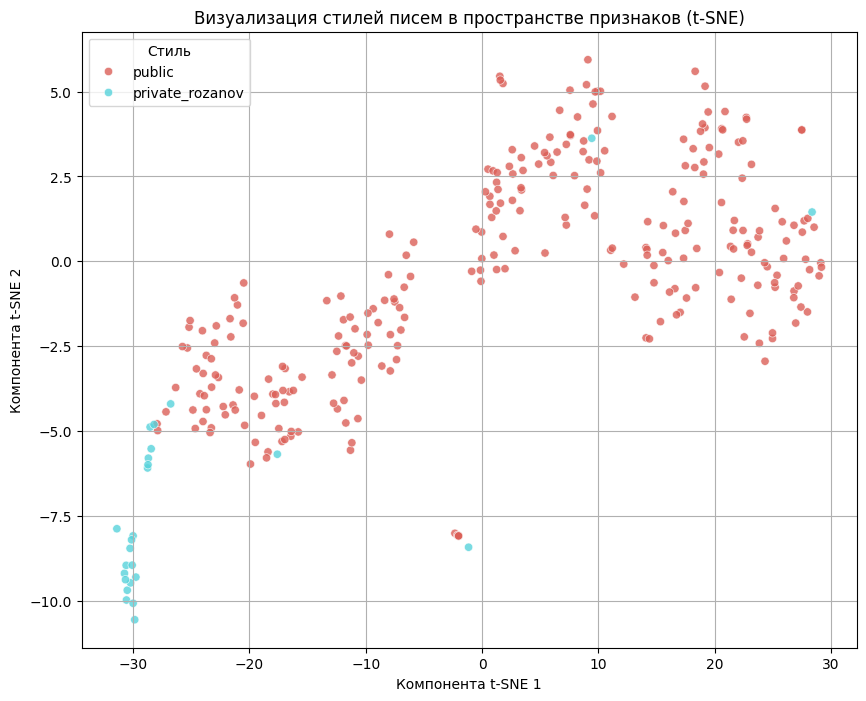

In [3]:
# --- Вариант 1: Визуализация t-SNE ---
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE

print("\n--- Визуализация 1: Распределение классов в 2D (t-SNE) ---")

# Убедимся, что у нас есть данные для визуализации
if not features_df.empty:
    # Используем те же данные, что и для модели
    X_scaled = scaler.transform(X) # Используем отмасштабированные данные

    # Применяем t-SNE для снижения размерности до 2 компонент
    tsne = TSNE(n_components=2, random_state=42, perplexity=min(30, len(X)-1))
    X_tsne = tsne.fit_transform(X_scaled)

    # Создаем DataFrame для удобства отрисовки
    tsne_df = pd.DataFrame(data=X_tsne, columns=['tsne_1', 'tsne_2'])
    tsne_df['style'] = y.values

    # Рисуем график
    plt.figure(figsize=(10, 8))
    sns.scatterplot(
        x='tsne_1', y='tsne_2',
        hue='style',
        palette=sns.color_palette("hls", 2),
        data=tsne_df,
        legend="full",
        alpha=0.8
    )
    plt.title('Визуализация стилей писем в пространстве признаков (t-SNE)')
    plt.xlabel('Компонента t-SNE 1')
    plt.ylabel('Компонента t-SNE 2')
    plt.legend(title='Стиль')
    plt.grid(True)
    plt.show()


# **Анализ важности признаков**

**Цель:** Понять, какие именно структурные характеристики графа оказались наиболее важными для разделения стилей. Модель SVM с линейным ядром позволяет нам посмотреть на "веса" (коэффициенты), которые она присвоила каждому признаку.



--- Визуализация 2: Важность признаков ---


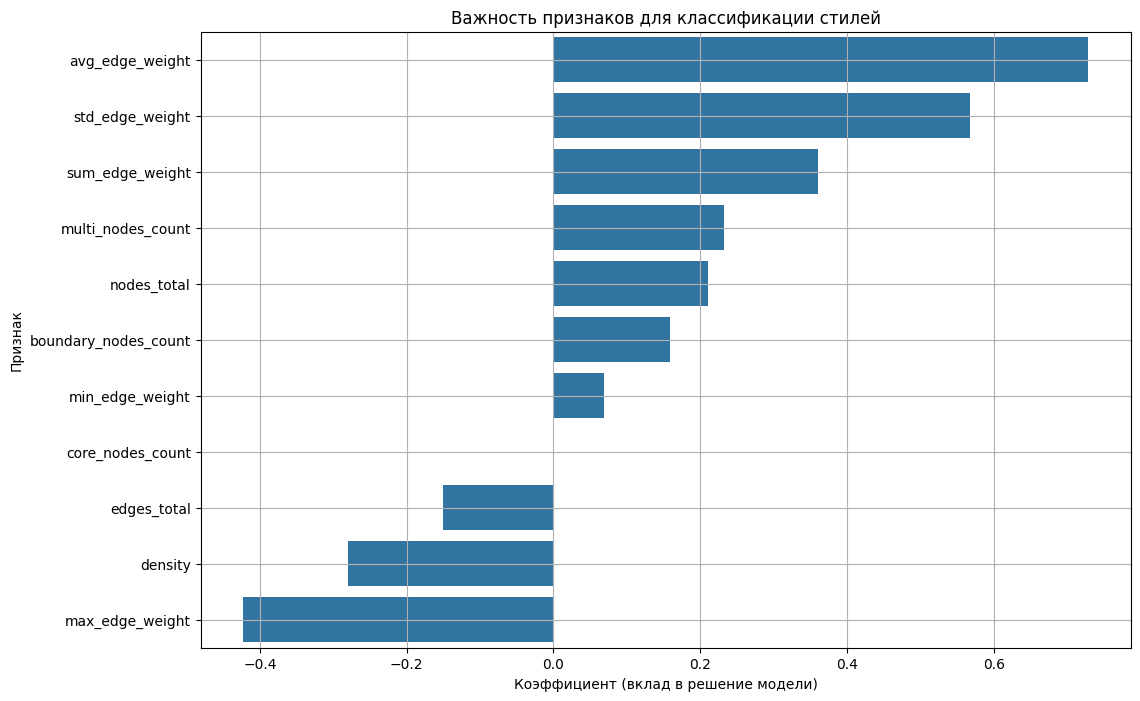

In [4]:
# --- Вариант 2: Важность признаков для модели SVM ---
print("\n--- Визуализация 2: Важность признаков ---")

if hasattr(model, 'coef_'):
    # Создаем DataFrame с признаками и их коэффициентами
    feature_importance = pd.DataFrame({
        'feature': X.columns,
        'importance': model.coef_[0]
    }).sort_values('importance', ascending=False)

    # Рисуем горизонтальный bar-plot
    plt.figure(figsize=(12, 8))
    sns.barplot(x='importance', y='feature', data=feature_importance)
    plt.title('Важность признаков для классификации стилей')
    plt.xlabel('Коэффициент (вклад в решение модели)')
    plt.ylabel('Признак')
    plt.grid(True)
    plt.show()

# **Интерпретация графика:**

Основываясь на графике, мы можем сделать следующие выводы о стилях Суворина:

**"Публичный"** стиль (положительные признаки) характеризуется:

**Avg_edge_weight (средний вес ребер)**

Оснвной маркер стиля. В публичных письмах семантическая связь между ключевыми и связанными с ними словами в среднем сильнее. Это может говорить о более сфокусированной и тематически плотной лексике.

**Std_edge_weight (стандартное отклонение весов)**

В публичных письмах наблюдается большее разнообразие в силе семантических связей.

**Multi_nodes_count (количество мульти-узлов)**

В публичных текстах больше слов, которые тематически связывают сразу несколько ключевых понятий. Это логично для публицистики.


**"Личный"** стиль (отрицательные признаки) характеризуется:

**Max_edge_weight (максимальный вес ребра)**

Основной маркер стиля. В письмах к Розанову встречаются отдельные, но очень сильные семантические пары. Возможно, это какие-то специфические, общие для них понятия или инсайды, которые создают очень тесную связь между словами.

**density (плотность графа) и edges_total (общее число ребер)**

Эти признаки имеют отрицательный вклад. Это значит, что графы личных писем в целом менее плотные и содержат меньше связей, несмотря на наличие очень сильных отдельных пар. Это может указывать на более свободный, менее тематически сфокусированный стиль письма.

**Итоговый вывод:** визуализация позволяет утверждать, что "модель не просто работает", а делать конкретные выводы о стиле. Публичный стиль А.С. Суворина создает более плотные, тематически насыщенные семантические графы, в то время как его личный стиль характеризуется более "разреженной" структурой, но с отдельными, очень яркими и сильными смысловыми связями.

# **Сравнение распределений ключевых признаков**

**Цель:** Сравнить распределения значений для самых важных признаков между двумя стилями.

Box plot (ящик с усами) наглядно покажет, как различаются медианы, разброс и выбросы для конкретного признака (например, density) у "публичных" и "личных" писем.


--- Визуализация 3: Сравнение распределения признаков ---


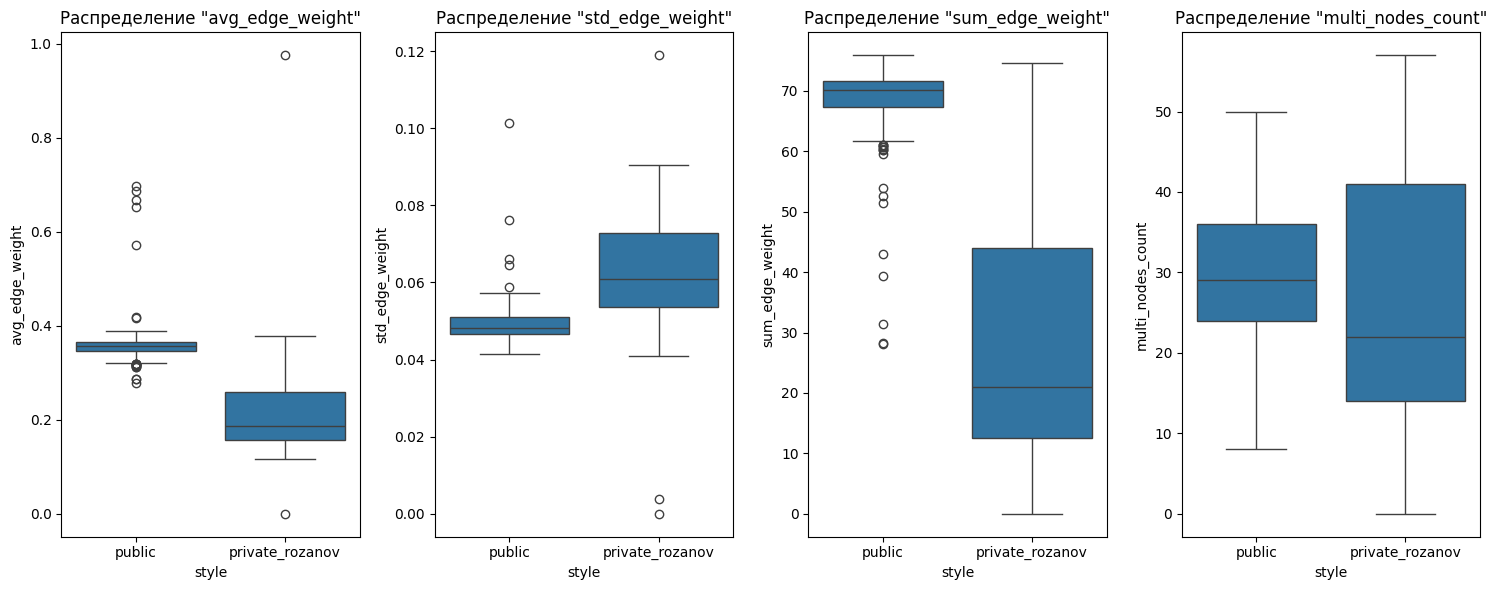

In [5]:
# --- Вариант 3: Сравнительные Box-plots ---
print("\n--- Визуализация 3: Сравнение распределения признаков ---")

# Выберем несколько интересных признаков для сравнения (например, 4 самых важных из предыдущего графика)
if not features_df.empty and 'feature_importance' in locals():
    top_features = feature_importance['feature'].head(4).tolist()

    plt.figure(figsize=(15, 6))
    for i, feature in enumerate(top_features, 1):
        plt.subplot(1, 4, i)
        sns.boxplot(x='style', y=feature, data=features_df)
        plt.title(f'Распределение "{feature}"')
    plt.tight_layout()
    plt.show()


# **Интерпретация четырех графиков**

Мы видим четыре самых важных признака, которые наша модель сочла маркерами "публичного" стиля.

**Распределение "avg_edge_weight" (Средний вес ребер)**

"Ящик" для public стиля расположен значительно выше, чем для private_rozanov.
**Вывод**: Медианное значение среднего веса ребер в публичных письмах гораздо выше. Это наглядное подтверждение вывода из предыдущего графика: публичный стиль А.С. Суворина характеризуется более тесными семантическими связями в целом.

**Распределение "std_edge_weight" (Стандартное отклонение весов)**

"Ящик" для public стиля снова выше и имеет больший размер.
**Вывод:** В публичных письмах не только выше средняя сила связей, но и больше разнообразие (разброс) в этой силе. То есть там встречаются как очень сильные, так и средние связи, в то время как в личных письмах сила связей более однородна и в целом ниже.


**Распределение "sum_edge_weight" (Сумма весов ребер)**:

Аналогично первому графику, "ящик" public стиля находится на порядок выше.
**Вывод:** Общая "семантическая энергия" графа в публичных письмах значительно выше. Это логично, так как они, вероятно, более объемные и тематически насыщенные.

**Распределение "multi_nodes_count" (Количество мульти-узлов)**

Медиана для public стиля заметно выше, чем для private_rozanov.
**Вывод:** В публичных письмах больше слов, которые служат "смысловыми мостами" между несколькими ключевыми темами. *Это хорошо соответствует природе публицистического текста, где нужно связывать воедино разные идеи для широкой аудитории.*

**Итоговое заключение по этой визуализации:**
Эти графики подтверждают и детализируют выводы, сделанные на основе "важности признаков". Они наглядно демонстрируют, что различия между стилями — это не случайность, а стабильная и измеримая закономерность. Графы "публичных" писем в среднем более сложные, с более сильными и разнообразными связями, и с большим количеством тематических "перекрестков".

# **Визуализация графов**

**Цель: **Наглядно продемонстрировать структурные различия, которые уловила модель. Это прямая иллюстрация методологии из статьи.

Сможем визуально сравнить граф для типичного "публичного" письма и типичного "личного" письма и увидеть разницу в их структуре, плотности, количестве узлов разных типов.


--- Визуализация 4: Пример графов для двух стилей ---


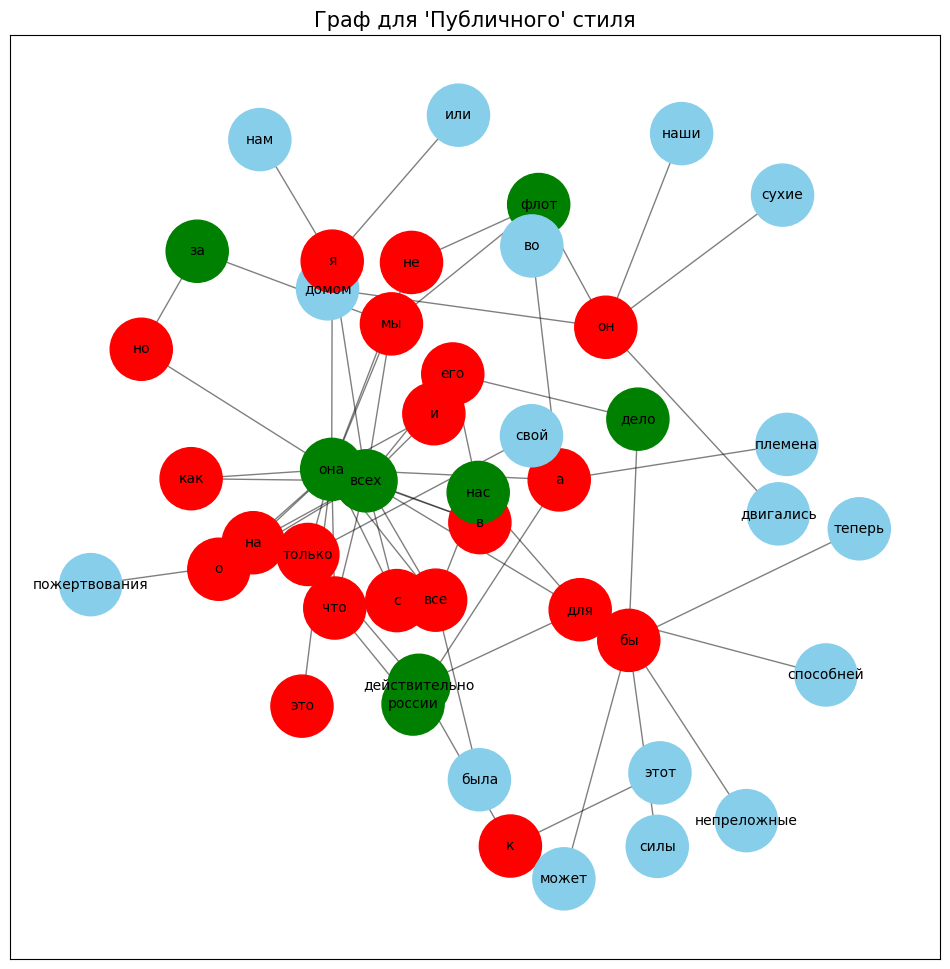

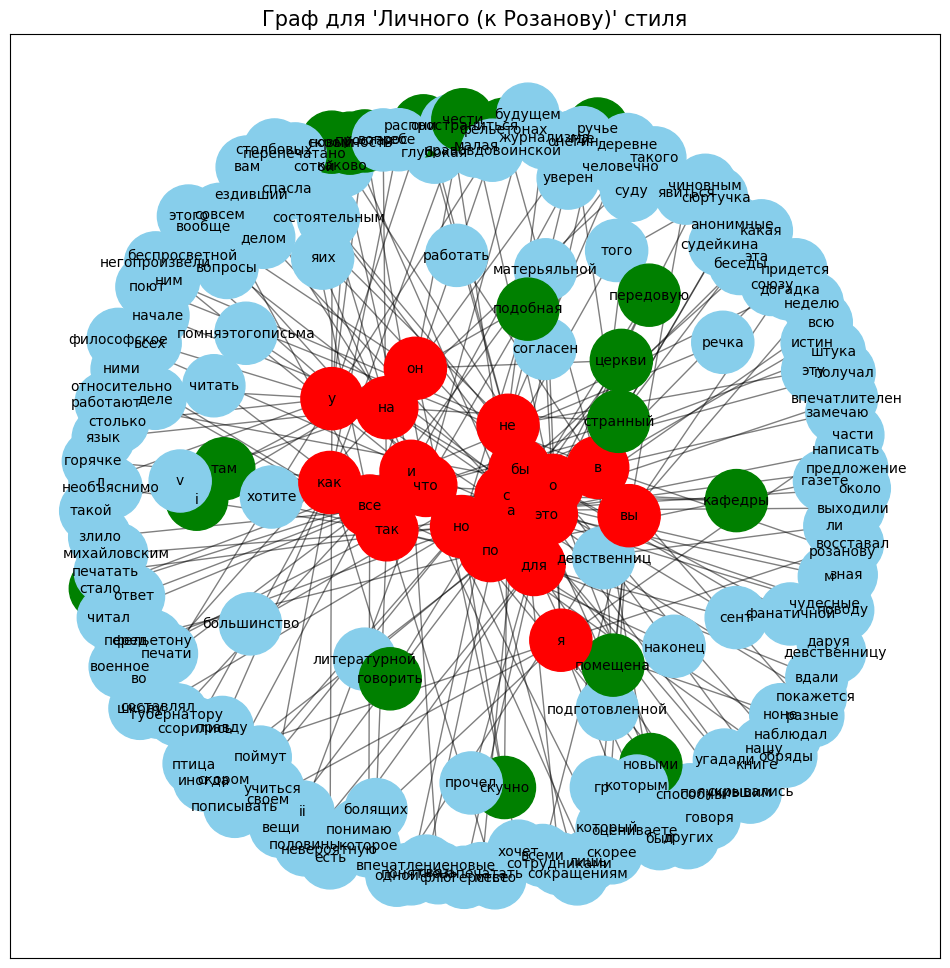

In [6]:
# --- Вариант 4: Визуализация графов ---
import networkx as nx

print("\n--- Визуализация 4: Пример графов для двух стилей ---")

# Функция для отрисовки графа
def draw_style_graph(graph, title):
    if graph is None:
        print(f"Невозможно построить график для '{title}': граф не создан.")
        return

    plt.figure(figsize=(12, 12))
    pos = nx.spring_layout(graph, k=0.5, iterations=50) # Расположение узлов

    # Цвета для разных типов узлов
    node_colors = []
    node_types = nx.get_node_attributes(graph, 'type')
    for node in graph.nodes():
        if node_types.get(node) == 'core':
            node_colors.append('red')
        elif node_types.get(node) == 'multi':
            node_colors.append('green')
        else:
            node_colors.append('skyblue')

    nx.draw_networkx_nodes(graph, pos, node_color=node_colors, node_size=2000)
    nx.draw_networkx_edges(graph, pos, width=1.0, alpha=0.5)
    nx.draw_networkx_labels(graph, pos, font_size=10, font_family='sans-serif')

    plt.title(title, size=15)
    plt.show()

# Выбираем по одному примеру каждого стиля
public_sample_text = final_df[final_df['style'] == 'public']['text'].iloc[0]
private_sample_text = final_df[final_df['style'] == 'private_rozanov']['text'].iloc[0]

# Создаем и рисуем графы
public_tokens = preprocess_text(public_sample_text)
public_graph = create_document_graph(public_tokens)
draw_style_graph(public_graph, "Граф для 'Публичного' стиля")

private_tokens = preprocess_text(private_sample_text)
private_graph = create_document_graph(private_tokens)
draw_style_graph(private_graph, "Граф для 'Личного (к Розанову)' стиля")


# **Выводы:**

Проведенное исследование подтвердило высокую эффективность графовых моделей **Word2vec** для стилометрического анализа русскоязычных эпистолярных текстов. Поставленная гипотеза о том, что структурные признаки семантических графов способны улавливать стилистические вариации одного автора, обусловленные различными коммуникативными контекстами (публичный и личный), была полностью подтверждена.

Достигнутые показатели **качества классификации** (общая точность 99%, F1-мера для миноритарного класса 0.93) свидетельствуют о высокой чувствительности и надежности метода. Анализ важности признаков показал, что "публичный" стиль А.С. Суворина характеризуется более высокой средней силой семантических связей и большим количеством тематических "мульти-узлов", в то время как "личный" стиль отличается наличием отдельных, но очень сильных семантических пар при общей меньшей плотности графа.

Эти результаты говорят о перспективности применения данного подхода для решения тонких задач стилометрии, выходящих за рамки простой атрибуции авторства. Метод может найти применение в исследованиях эволюции авторского стиля, анализе влияния аудитории на стилистические характеристики текста и изучении жанровых особенностей письменной речи.

# **Ограничения исследования**

Настоящее исследование имеет ряд ограничений, которые следует учитывать при интерпретации результатов. Значительный дисбаланс между размерами корпусов может приводить к переобучению модели на мажоритарном классе. Упрощенная процедура извлечения признаков не включает полный спектр характеристик, предусмотренных базовой методологией. Отсутствие сравнения с альтернативными методами стилометрического анализа затрудняет оценку относительной эффективности предложенного подхода. Исследование ограничивается материалом одного автора, что не позволяет оценить обобщающую способность метода.

# **Источники**

*Суворин А.C.* Русско-японская война и русская революция. Маленькие письма (1904–1908). М. : Алгоритм, 2005. 720 с.

*Розанов В. В.* Собрание сочинений. Признаки времени (Статьи и очерки 1912 г.) М.: Республика, Алгоритм, 2006.

*Tripto N.I., Ali M.E.* The Word2vec Graph Model for Author Attribution and Genre Detection in Literary Analysis // arXiv preprint arXiv:2310.16972. 2023.